In [1]:
from BehaviorAnalyst import BehaviorAnalyst
import pandas as pd
import numpy as np
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# plt.style.use('ggplot')

In [2]:
Dataframe = pd.read_hdf("../DeepLabCutV2/cow-sky-2019-01-27/labeled-data/cow/CollectedData_Sky.h5")

In [3]:
Dataframe.head(5)

scorer                  Sky                                                  \
bodyparts        Body_Cow_A         Body_Cow_B          Body_Cow_C            
coords                    x       y          x        y          x        y   
data/img0000.png     234.24  307.20    764.000  361.333    258.667  686.667   
data/img0250.png     719.36  398.08    441.333  116.000   1240.000  521.333   
data/img0251.png     719.36  399.36    438.667  114.667   1242.667  517.333   
data/img0252.png     719.36  399.36    438.667  114.667   1245.333  518.667   
data/img0253.png     719.36  399.36    438.667  114.667   1254.667  516.000   

scorer                                                                     \
bodyparts        Bottom_Cow_A          Bottom_Cow_B          Bottom_Cow_C   
coords                      x        y            x        y            x   
data/img0000.png       54.400  388.267      571.733  187.733      293.333   
data/img0250.png      987.733  362.667      710.400   70.400     1099.733   
data/img0251.png      987.733  362.667      709.333   70.400     1098.667   
data/img0252.png      987.733  362.667      709.333   72.533     1102.933   
data/img0253.png      987.733  362.667      707.200   69.333     1113.600   

scorer                                                                    \
bodyparts                 Nose_Cow_A          Nose_Cow_B      Nose_Cow_C   
coords                  y          x        y          x    y          x   
data/img0000.png  504.533    645.333  289.067        0.0  0.0     362.24   
data/img0250.png  516.267      0.000    0.000        0.0  0.0       0.00   
data/img0251.png  516.267      0.000    0.000        0.0  0.0       0.00   
data/img0252.png  508.800      0.000    0.000        0.0  0.0       0.00   
data/img0253.png  506.667      0.000    0.000        0.0  0.0       0.00   

scorer                    
bodyparts                 
coords                 y  
data/img0000.png  872.96  
data/img0250.png    0.00  
data/img0251.png    0.00  
data/img0252.png    0.00  
data/img0253.png    0.00

In [21]:
scorer = np.unique(Dataframe.columns.get_level_values(0))[0]
print("Scorer:", scorer)
nframes = len(Dataframe.index)
print("Number of Frames:", nframes)
cows = ['Cow_A', 'Cow_B', 'Cow_C']
bodyparts = ['Nose_', 'Bottom_', 'Body_']
bodyparts2compare = {
    'Nose_': bodyparts,
    'Bottom_': bodyparts,
    'Body_': bodyparts
}
MARKER_CUTOFF = 1
analyst = BehaviorAnalyst()
features = collections.defaultdict(dict)
folder2save = 'extracted_features/'
folder2save_heat_labels = 'heat_labels/'
MECHANICS_FEATURE_NAMES = ['distance', 'velocity', 'acceleration']
cows_id = {
    'None': 0,
    'Cow_A': 1,
    'Cow_B': 2,
    'Cow_C': 3
}

Scorer: Sky
Number of Frames: 1500


## Mechanics-based feature extraction
---

Note: ตอนหา distance ต้องลอง 3 แบบคือ
    1. จากจุดเริ่มต้น (frame 1)
    2. จากจุดจาก frame ก่อนหน้า
    3. accumulation

### A distance is started at the point on the first frame

In [5]:
mechanics_based_features_1st = "Mechanics_1st_"

In [15]:
mechanics_based_features_temp1 = collections.defaultdict(dict)
for cow in cows:
    T = 1
    for index in tqdm(range(nframes)):
        feature_container = dict()
        frame_name = Dataframe.index[index]
        for bodypart in bodyparts:
            S = np.Infinity
            V = np.Infinity
            A = np.Infinity
            if index != 0:
                x = Dataframe[scorer][bodypart + cow]['x'].values[index]
                y = Dataframe[scorer][bodypart + cow]['y'].values[index]
                x_comparative = Dataframe[scorer][bodypart + cow]['x'].values[0] # Every distance will be started at the point on the first frame
                y_comparative = Dataframe[scorer][bodypart + cow]['y'].values[0] # Every distance will be started at the point on the first frame
                if (((x >= MARKER_CUTOFF) or (y >= MARKER_CUTOFF)) and ((x_comparative >= MARKER_CUTOFF) or (y_comparative >= MARKER_CUTOFF))):
                    # if all of body parts appear.
                    point = [[x, y]]
                    point_comparative = [[x_comparative, y_comparative]]
                    S = analyst.calculateDistance(point, point_comparative)
                    V = S/T
#                     A = (feature_container[bodypart]['velocity'].values[index - 1] - V)/T
            
#             feature_container[bodypart] = {'distance': S, 'velocity': V, 'acceleration': A}
            feature_container[bodypart] = {'distance': S, 'velocity': V}
            
        mechanics_based_features_temp1[cow][frame_name] = feature_container
        T = T + 1
                    

100%|██████████| 1500/1500 [00:14<00:00, 100.05it/s]


In [7]:
mechanics_based_features_type1 = dict()
for cow in mechanics_based_features_temp1:
    df_cow_features = collections.defaultdict(dict)
    for index in range(len(MECHANICS_FEATURE_NAMES)):
        for bodypart in bodyparts:
            for feature in MECHANICS_FEATURE_NAMES:
                attribute = list()
                for frame in mechanics_based_features_temp1[cow]:
                    attribute.append(mechanics_based_features_temp1[cow][frame][bodypart][feature])
                df_cow_features[cow][feature + '_' + bodypart + cow] = pd.Series(attribute, index=list(mechanics_based_features_temp1[cow].keys()))
    mechanics_based_features_type1[cow] = pd.DataFrame(df_cow_features[cow])

KeyError: 'acceleration'

In [20]:
# Save data by this scorer
for cow in mechanics_based_features_type1:
    mechanics_based_features_type1[cow].to_csv(folder2save + mechanics_based_features_1st + "Features_" + scorer + "_" + cow + ".csv")
    mechanics_based_features_type1[cow].to_hdf(folder2save + mechanics_based_features_1st + "Features_" + scorer + "_" + cow + '.h5', 'df_with_missing', format='table', mode='w')

### A distance is started at the point on previous frame

In [38]:
mechanics_based_features_previous = "Mechanics_previous_"

In [39]:
mechanics_based_features_temp2 = collections.defaultdict(dict)
for cow in cows:
    T = 1
    for index in tqdm(range(nframes)):
        feature_container = dict()
        frame_name = Dataframe.index[index]
        for bodypart in bodyparts:
            S = np.Infinity
            V = np.Infinity
            A = np.Infinity
            if index != 0:
                x = Dataframe[scorer][bodypart + cow]['x'].values[index]
                y = Dataframe[scorer][bodypart + cow]['y'].values[index]
                x_comparative = Dataframe[scorer][bodypart + cow]['x'].values[index - 1] # Every distance will be started at the point on the first frame
                y_comparative = Dataframe[scorer][bodypart + cow]['y'].values[index - 1] # Every distance will be started at the point on the first frame
                if (((x >= MARKER_CUTOFF) or (y >= MARKER_CUTOFF)) and ((x_comparative >= MARKER_CUTOFF) or (y_comparative >= MARKER_CUTOFF))):
                    # if all of body parts appear.
                    point = [[x, y]]
                    point_comparative = [[x_comparative, y_comparative]]
                    S = analyst.calculateDistance(point, point_comparative)
                    V = S/T
                    A = V/T
            
            feature_container[bodypart] = {'distance': S, 'velocity': V, 'acceleration': A}
            
        mechanics_based_features_temp2[cow][frame_name] = feature_container
        T = T + 1
                    

100%|██████████| 1500/1500 [00:13<00:00, 109.15it/s]


In [43]:
mechanics_based_features_type2 = dict()
for cow in mechanics_based_features_temp2:
    df_cow_features = collections.defaultdict(dict)
    for index in range(len(MECHANICS_FEATURE_NAMES)):
        for bodypart in bodyparts:
            for feature in MECHANICS_FEATURE_NAMES:
                attribute = list()
                for frame in mechanics_based_features_temp2[cow]:
                    attribute.append(mechanics_based_features_temp2[cow][frame][bodypart][feature])
                df_cow_features[cow][feature + '_' + bodypart] = pd.Series(attribute, index=list(mechanics_based_features_temp2[cow].keys()))
    mechanics_based_features_type2[cow] = pd.DataFrame(df_cow_features[cow])

In [44]:
mechanics_based_features_type2['Cow_A'].head(5)

,distance_Nose_,velocity_Nose_,acceleration_Nose_,distance_Bottom_,velocity_Bottom_,acceleration_Bottom_,distance_Body_,velocity_Body_,acceleration_Body_
data/img0000.png,inf,inf,inf,inf,inf,inf,inf,inf,inf
data/img0250.png,inf,inf,inf,933.684020,466.842010,233.421005,493.559104,246.779552,123.389776
data/img0251.png,inf,inf,inf,0.000000,0.000000,0.000000,1.280000,0.426667,0.142222
data/img0252.png,inf,inf,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
data/img0253.png,inf,inf,inf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
# Save data by this scorer
for cow in mechanics_based_features_type2:
    mechanics_based_features_type2[cow].to_csv(folder2save + mechanics_based_features_previous + "Features_" + scorer + "_" + cow + ".csv")
    mechanics_based_features_type2[cow].to_hdf(folder2save + mechanics_based_features_previous + "Features_" + scorer + "_" + cow + '.h5', 'df_with_missing', format='table', mode='w')

### The distance is cumulation of previous frames

In [13]:
mechanics_based_features_temp3 = collections.defaultdict(dict)
for cow in cows:
    T = 1
    cumulative_S = {'Nose_':0, 'Body_':0, 'Bottom_':0}
    for index in tqdm(range(nframes)):
        feature_container = dict()
        frame_name = Dataframe.index[index]
        for bodypart in bodyparts:
            V = np.Infinity
            A = np.Infinity
            if index != 0:
                x = Dataframe[scorer][bodypart + cow]['x'].values[index]
                y = Dataframe[scorer][bodypart + cow]['y'].values[index]
                x_comparative = Dataframe[scorer][bodypart + cow]['x'].values[index - 1] # Every distance will be started at the point on the first frame
                y_comparative = Dataframe[scorer][bodypart + cow]['y'].values[index - 1] # Every distance will be started at the point on the first frame
                if (((x >= MARKER_CUTOFF) or (y >= MARKER_CUTOFF)) and ((x_comparative >= MARKER_CUTOFF) or (y_comparative >= MARKER_CUTOFF))):
                    # if all of body parts appear.
                    point = [[x, y]]
                    point_comparative = [[x_comparative, y_comparative]]
                    cumulative_S[bodypart] += analyst.calculateDistance(point, point_comparative)
                    V = cumulative_S[bodypart]/T
                    A = V/T
            
            feature_container[bodypart] = {'distance': cumulative_S[bodypart], 'velocity': V, 'acceleration': A}
            
        mechanics_based_features_temp3[cow][frame_name] = feature_container
        T = T + 1
                    

100%|██████████| 1500/1500 [00:14<00:00, 105.83it/s]


In [15]:
mechanics_based_feature_type3 = dict()
for cow in mechanics_based_features_temp3:
    df_cow_features = collections.defaultdict(dict)
    for index in range(len(MECHANICS_FEATURE_NAMES)):
        for bodypart in bodyparts:
            for feature in MECHANICS_FEATURE_NAMES:
                attribute = list()
                for frame in mechanics_based_features_temp3[cow]:
                    attribute.append(mechanics_based_features_temp3[cow][frame][bodypart][feature])
                df_cow_features[cow][feature + '_' + bodypart + cow] = pd.Series(attribute, index=list(mechanics_based_features_temp3[cow].keys()))
    mechanics_based_feature_type3[cow] = pd.DataFrame(df_cow_features[cow])

## Distance-based feature extraction
---

In [27]:
for cow in cows:
    for index in tqdm(range(nframes)):
        frame_name = Dataframe.index[index]
        feature_container = list()
        for part2compare in bodyparts2compare:
            point_appearance = 0
            for pair2compare in bodyparts2compare[part2compare]:
                distances = {'None': np.Infinity}
                for comparative_cow in cows:
                    if comparative_cow != cow:
                        x = Dataframe[scorer][part2compare + cow]['x'].values[index]
                        y = Dataframe[scorer][part2compare + cow]['y'].values[index]
                        if ((x >= MARKER_CUTOFF) or (y >= MARKER_CUTOFF)):
                            point_appearance = 1
                            x_comparative = Dataframe[scorer][pair2compare + comparative_cow]['x'].values[index]
                            y_comparative = Dataframe[scorer][pair2compare + comparative_cow]['y'].values[index]
                            if ((x_comparative >= MARKER_CUTOFF) or (y_comparative >= MARKER_CUTOFF)):
                                # if all of body parts appear.
                                point = [[x, y]]
                                point_comparative = [[x_comparative, y_comparative]]
                                dist = analyst.calculateDistance(point, point_comparative)
                                distances[comparative_cow] = dist

                feature_container.append(min(distances.values()))
                feature_container.append(cows_id[list(distances.keys())[list(distances.values()).index(min(distances.values()))]])
            feature_container.append(point_appearance)
        features[cow][frame_name] = feature_container

100%|██████████| 1500/1500 [01:16<00:00, 15.25it/s]


In [31]:
FEATURE_NAMES = ['nearest_dist_head2head', 
                 'nearest_cow_head2head', 
                 'nearest_dist_head2bottom', 
                 'nearest_cow_head2bottom', 
                 'nearest_dist_head2body', 
                 'nearest_cow_head2body', 
                 'head_appearance',
                 'nearest_dist_bottom2head',
                 'nearest_cow_bottom2head',
                 'nearest_dist_bottom2bottom', 
                 'nearest_cow_bottom2bottom',
                 'nearest_dist_bottom2body',
                 'nearest_cow_bottom2body',
                 'bottom_appearance',
                 'nearest_dist_body2head',
                 'nearest_cow_body2head',
                 'nearest_dist_body2bottom',
                 'nearest_cow_body2bottom',
                 'nearest_dist_body2body',
                 'nearest_cow_body2body',
                 'body_appearance']
df_cows_features = dict()
for cow in features:
    df_cow_features = collections.defaultdict(dict)
    for index in range(len(FEATURE_NAMES)):
        attribute = list()
        for frame in features[cow]:
            attribute.append(features[cow][frame][index])
        df_cow_features[cow][FEATURE_NAMES[index]] = pd.Series(attribute, index=list(features[cow].keys()))
    df_cows_features[cow] = pd.DataFrame(df_cow_features[cow])

In [32]:
df_cows_features['Cow_A'].head(5)

,nearest_dist_head2head,nearest_cow_head2head,nearest_dist_head2bottom,nearest_cow_head2bottom,nearest_dist_head2body,nearest_cow_head2body,head_appearance,nearest_dist_bottom2head,nearest_cow_bottom2head,nearest_dist_bottom2bottom,...,nearest_dist_bottom2body,nearest_cow_bottom2body,bottom_appearance,nearest_dist_body2head,nearest_cow_body2head,nearest_dist_body2bottom,nearest_cow_body2bottom,nearest_dist_body2body,nearest_cow_body2body,body_appearance
data/img0000.png,648.901134,3,125.241924,2,138.939669,2,1,574.188793,3,265.719328,...,361.617985,3,1,580.058943,3,205.991008,3,380.252393,3,1
data/img0250.png,inf,0,inf,0,inf,0,0,inf,0,190.097238,...,298.016004,3,1,inf,0,327.802477,2,396.065827,2,1
data/img0251.png,inf,0,inf,0,inf,0,0,inf,0,189.471139,...,298.182689,3,1,inf,0,329.112781,2,399.798280,2,1
data/img0252.png,inf,0,inf,0,inf,0,0,inf,0,186.080342,...,301.154047,3,1,inf,0,326.980777,2,399.798280,2,1
data/img0253.png,inf,0,inf,0,inf,0,0,inf,0,191.255070,...,307.838869,3,1,inf,0,330.250944,2,399.798280,2,1


In [33]:
# Save data by this scorer
for cow in df_cows_features:
    df_cows_features[cow].to_csv(folder2save + "ExtractedFeatures_" + scorer + "_" + cow + ".csv")
    df_cows_features[cow].to_hdf(folder2save + "ExtractedFeatures_" + scorer + "_" + cow + '.h5', 'df_with_missing', format='table', mode='w')

In [57]:
# Read extracted feature files
extracted_features = dict()
for cow in cows:
    extracted_features[cow] = pd.read_hdf(folder2save + 'ExtractedFeatures_Sky_' + cow + '.h5')

In [58]:
extracted_features['Cow_A'].head(5)

,nearest_dist_head2head,nearest_cow_head2head,nearest_dist_head2bottom,nearest_cow_head2bottom,nearest_dist_head2body,nearest_cow_head2body,head_appearance,nearest_dist_bottom2head,nearest_cow_bottom2head,bottom_appearance
data/img0000.png,648.901134,Cow_C,125.241924,Cow_B,138.939669,Cow_B,1,574.188793,Cow_C,1
data/img0250.png,inf,None,inf,None,inf,None,0,inf,None,0
data/img0251.png,inf,None,inf,None,inf,None,0,inf,None,0
data/img0252.png,inf,None,inf,None,inf,None,0,inf,None,0
data/img0253.png,inf,None,inf,None,inf,None,0,inf,None,0


## Heat-tracking feature extraction

In [ ]:
for cow in cows:
    for index in tqdm(range(nframes)):
        frame_name = Dataframe.index[index]
        feature_container = list()
        for part2compare in bodyparts2compare:
            point_appearance = 0
            for pair2compare in bodyparts2compare[part2compare]:
                distances = {'None': np.Infinity}
                for comparative_cow in cows:
                    if comparative_cow != cow:
                        x = Dataframe[scorer][part2compare + cow]['x'].values[index]
                        y = Dataframe[scorer][part2compare + cow]['y'].values[index]
                        x_comparative = Dataframe[scorer][pair2compare + comparative_cow]['x'].values[index]
                        y_comparative = Dataframe[scorer][pair2compare + comparative_cow]['y'].values[index]
                        if (((x >= MARKER_CUTOFF) or (y >= MARKER_CUTOFF)) and ((x_comparative >= MARKER_CUTOFF) or (y_comparative >= MARKER_CUTOFF))):
                            # if all of body parts appear.
                            point = [[x, y]]
                            point_comparative = [[x_comparative, y_comparative]]
                            dist = analyst.calculateDistance(point, point_comparative)
#                             distances.append(dist)
                            distances[comparative_cow] = dist
                            point_appearance = 1
#                         else:
#                             distances.append(-np.Infinity)

#                 feature_container.append(min(distances))
                feature_container.append(min(distances.values()))
                feature_container.append(list(distances.keys())[list(distances.values()).index(min(distances.values()))])
            feature_container.append(point_appearance)
        features[cow][frame_name] = feature_container

## Shape-based feature extraction

Note: ถ้าจุดใน frame นั้นหาย ให้ย้อนไปหาที่ frame ล่าสุดที่เจอ

## Coordinate-based feature extraction

In [34]:
coordinate_features = collections.defaultdict(dict)
for cow in cows:
    for index in tqdm(range(nframes)):
        frame_name = Dataframe.index[index]
        feature_container = list()
        for bodypart in bodyparts:
            x = Dataframe[scorer][bodypart + cow]['x'].values[index]
            y = Dataframe[scorer][bodypart + cow]['y'].values[index]
            feature_container.append(x)
            feature_container.append(y)
        coordinate_features[cow][frame_name] = feature_container

100%|██████████| 1500/1500 [00:06<00:00, 224.68it/s]


In [35]:
NAME_OF_COORDI_FEATURES = ['Coordi_Nose_x', 'Coordi_Nose_y', 'Coordi_Bottom_x', 'Coordi_Bottom_y', 'Coordi_Body_x', 'Coordi_Body_y']
df_coordinate_features = dict()
for cow in coordinate_features:
    temp_features = collections.defaultdict(dict)
    for index in range(len(NAME_OF_COORDI_FEATURES)):
        attribute = list()
        for frame in coordinate_features[cow]:
            attribute.append(coordinate_features[cow][frame][index])
        temp_features[cow][NAME_OF_COORDI_FEATURES[index]] = pd.Series(attribute, index=list(coordinate_features[cow].keys()))
    df_coordinate_features[cow] = pd.DataFrame(temp_features[cow])

In [36]:
df_coordinate_features['Cow_A'].head(5)

,Coordi_Nose_x,Coordi_Nose_y,Coordi_Bottom_x,Coordi_Bottom_y,Coordi_Body_x,Coordi_Body_y
data/img0000.png,645.333,289.067,54.400,388.267,234.24,307.20
data/img0250.png,0.000,0.000,987.733,362.667,719.36,398.08
data/img0251.png,0.000,0.000,987.733,362.667,719.36,399.36
data/img0252.png,0.000,0.000,987.733,362.667,719.36,399.36
data/img0253.png,0.000,0.000,987.733,362.667,719.36,399.36


In [37]:
# Save data by this scorer
for cow in df_coordinate_features:
    df_coordinate_features[cow].to_csv(folder2save + "CoordinateFeatures_" + scorer + "_" + cow + ".csv")
    df_coordinate_features[cow].to_hdf(folder2save + "CoordinateFeatures_" + scorer + "_" + cow + '.h5', 'df_with_missing', format='table', mode='w')

## Heat labeling 

In [8]:
frames = list(extracted_features['Cow_A'].index)

In [27]:
initial_data = {'implying': ['x' for frame in range(len(frames))]}

In [31]:
# Initialize labels
heat_labels = dict()
for cow in cows:
    heat_labels[cow] = pd.DataFrame(initial_data, index=frames)

In [25]:
heat_labels['Cow_B'].head(5)

,implying
data/img0000.png,3
data/img0250.png,0
data/img0251.png,0
data/img0252.png,0
data/img0253.png,0


In [38]:
# Save the initialized data
for cow in heat_labels:
    heat_labels[cow].to_csv(folder2save_heat_labels + "ImpliedHeatLabels_" + scorer + "_" + cow + ".csv")

In [5]:
# Read label files
heat_labels = dict()
for cow in cows:
    heat_labels[cow] = pd.read_csv(folder2save_heat_labels + "ImpliedHeatLabels_" + scorer + "_" + cow + ".csv", index_col=0)

In [6]:
heat_labels['Cow_C'].head(5)

,implying
data/img0000.png,0
data/img0250.png,0
data/img0251.png,0
data/img0252.png,0
data/img0253.png,0


In [7]:
for cow in cows:
    for index in heat_labels[cow]['implying'].index:
        label = heat_labels[cow]['implying'][index]
        if (label == 2) or (label == 3):
            heat_labels[cow]['implying'][index] = 1
        elif (label == 4):
            heat_labels[cow]['implying'][index] = 0

In [15]:
x_axis_collector = dict()
y_axis_collector = dict()
for cow in cows:
    y_axis = []
    temp = 0
    for index in range(len(heat_labels[cow]['implying'])):
        label = heat_labels[cow]['implying'][index]
        if index == 0:
            y_axis.append(label)
            temp = label
        else:
            temp += label
            y_axis.append(temp)

    x_axis_collector[cow] = np.array([x for x in range(1, len(heat_labels[cow]) + 1)])
    y_axis_collector[cow] = np.array(y_axis)

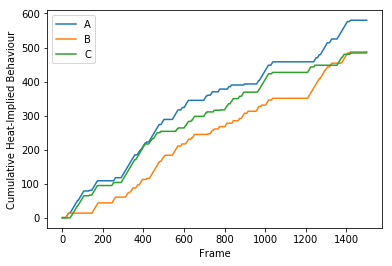

In [19]:
for cow in cows:
    plt.plot(x_axis_collector[cow], y_axis_collector[cow], linewidth=1.5, label=cow[len(cow) - 1])
plt.xlabel('Frame')
plt.ylabel('Cumulative Heat-Implied Behaviour')
plt.legend(loc='upper left')
plt.savefig('labels.png')
plt.show()